<center> <h2>Projet Finance Quantitative</h2> </center> <br>
<center> <h3>Master 2 MoSEF Data Science - Université Paris 1 Panthéon-Sorbonne</h3> </center> <br>
<center> <h3><b>Genetic Algorithm-optimized Triple Barrier Labeling for Predictive Stock Trading Using GBM Stacking</b></h3> </center> <br>
<center> <h3>Louis LEBRETON</h3> </center> <br>

# Création des DataFrames d'entraînement et de test

Les dataframes d'entraînement et de test sont générés à partir des sources de données suivantes :  

### Sources des données

1. **Données macroéconomiques**  
   - Provenance : API **FRED** (St. Louis Federal Reserve).  

2. **Scores de Tweets**  
   - **Scraping des tweets** : Les tweets des comptes X centrés sur Bitcoin sont extraits.
   - **Analyse des sentiments** : Les tweets sont transformés en scores numériques grâce au modèle **BERTweet**, permettant de quantifier leur sentiment.

3. **Données Bitcoin (BTC)**  
   - **Collecte des données** : Les données Bitcoin sont obtenues via l'API **Coingecko**.
   - **Labellisation** : Les données sont étiquetées à l'aide de la méthode **Triple Barrier**, produisant trois labels :
     - **-1** : Sell (avec un nombre spécifique de bitcoins à vendre)
     - **0** : Hold
     - **1** : Buy (avec un nombre spécifique de bitcoins à acheter)
   - **Optimisation des paramètres** : Les paramètres de la méthode **Triple Barrier** sont optimisés par un **algorithme génétique** pour maximiser les performances d'une stratégie de trading.

### Stratégies de trading

Deux stratégies distinctes sont utilisées pour générer les datasets :  

1. Stratégie pour profil **High Risk, High Profit**  
   - Optimisation : Maximisation de 0.7 * profit - 0.3 * maximum drawdown   

2. Stratégie pour profil **Low Risk, Low Profit**  
   - Optimisation : Maximisation de 0.3 * profit - 0.7 * maximum drawdown  

### Période d'analyse

Les données couvrent une période de cinq années, en excluant l'impact de la pandémie de COVID-19 : **2018, 2019, 2022, 2023, 2024**.


In [72]:
start_date = '2024-01-01'
end_date = '2025-01-01'

In [73]:
import os
import json
import random
from functools import partial
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from concurrent.futures import ThreadPoolExecutor
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split

from df_building.get_data_API import get_economic_data, get_BTC_data
from df_building.get_sentiment_score import tweets_to_sentiment_scores
from df_building.get_data_scraping import scrape_tweets_one_account
from df_building.get_labels.triple_barrier_method import TripleBarrierMethod
from df_building.get_labels.GA_optimization import evaluate_individual, run_genetic_algorithm

### Récupération des données macroéconomique

Je collecte des variables macroéconomiques pertinentes pour prédire les mouvements de prix du Bitcoin

In [74]:
# clef API FRED obtenue via https://fred.stlouisfed.org/docs/api/api_key.html
FRED_API_KEY = os.getenv('FRED_API_KEY')

# variables d'intérêt
series_list = [
    'DFF',       # Federal Funds Rate
    'NFINCP',    # Nonfinancial commercial paper outstanding
    'FINCP',     # Financial commercial paper outstanding
    'DPRIME',    # Bank prime loan rate
    'DPCREDIT',  # Discount window primary credit
    'DTWEXBGS',  # Nominal Broad U.S. Dollar Index
    'CPIAUCSL',  # Consumer Price Index
    'DGS3MO',    # Market Yield on U.S. Treasury Securities (3 months)
    'DGS1',      # Market Yield on U.S. Treasury Securities (1 year)
    'DGS30'      # Market Yield on U.S. Treasury Securities (30 years)
]

df_economic = get_economic_data(series_id_list=series_list, api_key=FRED_API_KEY, start_date=start_date, end_date=end_date)

df_economic.index = df_economic['date']
df_economic.drop(columns=['date'], inplace=True)

df_economic.head()


,DFF,NFINCP,FINCP,DPRIME,DPCREDIT,DTWEXBGS,CPIAUCSL,DGS3MO,DGS1,DGS30
date,,,,,,,,,,
2024-01-01,5.33,NaN,NaN,8.5,5.5,NaN,309.685,NaN,NaN,NaN
2024-01-02,5.33,NaN,NaN,8.5,5.5,119.6165,NaN,5.46,4.80,4.08
2024-01-03,5.33,273.0175,636.064172,8.5,5.5,120.0407,NaN,5.48,4.81,4.05
2024-01-04,5.33,NaN,NaN,8.5,5.5,119.9775,NaN,5.48,4.85,4.13
2024-01-05,5.33,NaN,NaN,8.5,5.5,119.7474,NaN,5.47,4.84,4.21


Traitement des données manquantes des variables macroéconomiques

In [75]:
df_economic['CPIAUCSL'] = df_economic['CPIAUCSL'].ffill() # sans traitement : seulement une valeur par mois
df_economic['FINCP'] = df_economic['FINCP'].bfill()       # sans traitement : seulement une valeur par semaine
df_economic['NFINCP'] = df_economic['NFINCP'].bfill()     # sans traitement : seulement une valeur par semaine

# traitement des autres valeurs manquantes par interpolation linéaire
for col in df_economic.columns:
    df_economic[col] = df_economic[col].interpolate()
    df_economic[col] = df_economic[col].bfill()
    df_economic[col] = df_economic[col].ffill()                                       
print('Taux valeurs manquantes:\n', df_economic.isna().sum() / len(df_economic))


Taux valeurs manquantes:
 DFF         0.0
NFINCP      0.0
FINCP       0.0
DPRIME      0.0
DPCREDIT    0.0
DTWEXBGS    0.0
CPIAUCSL    0.0
DGS3MO      0.0
DGS1        0.0
DGS30       0.0
dtype: float64


Visualisation des variables macroéconomiques

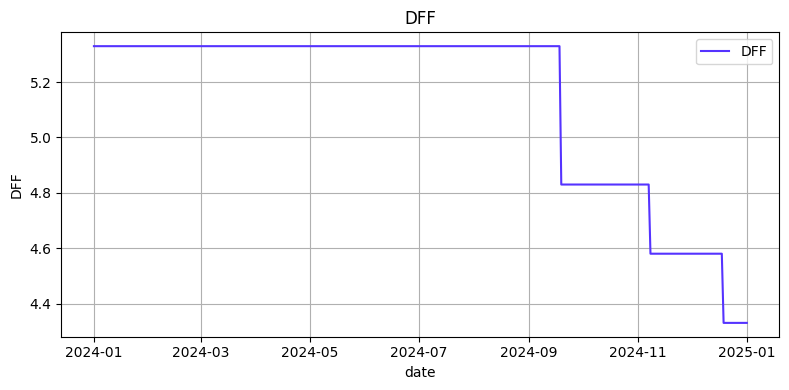

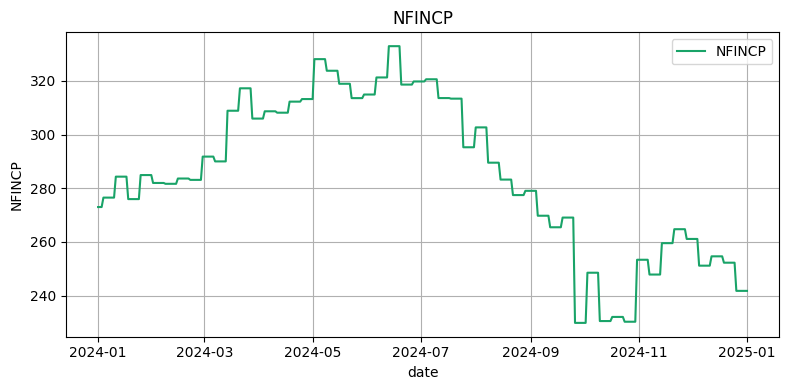

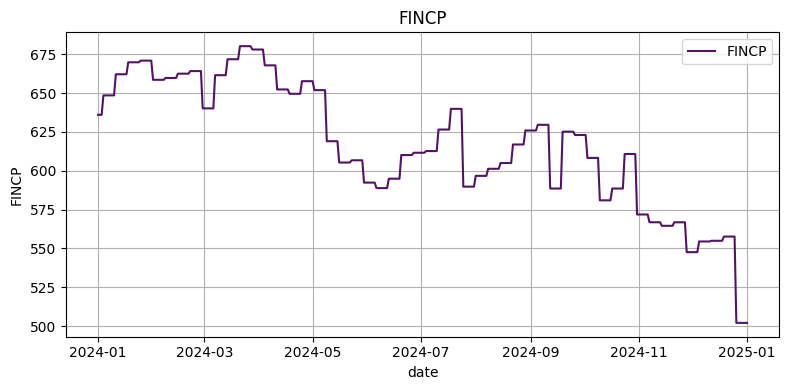

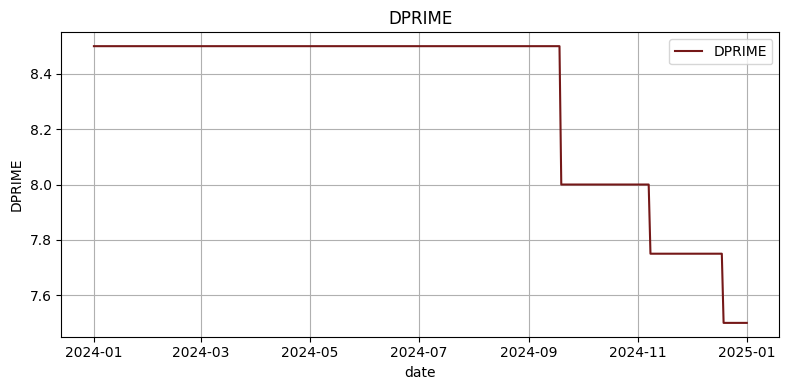

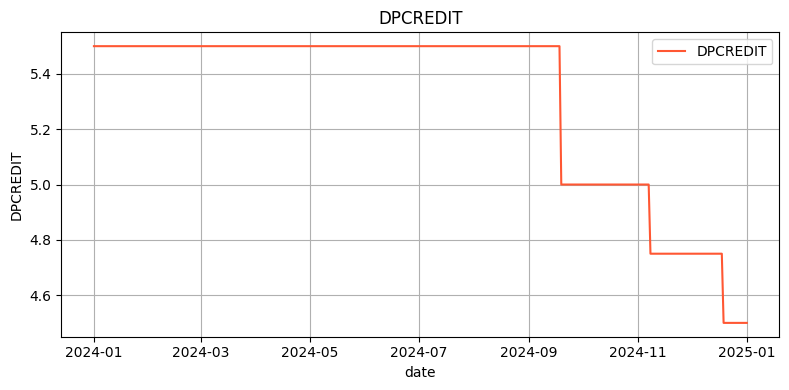

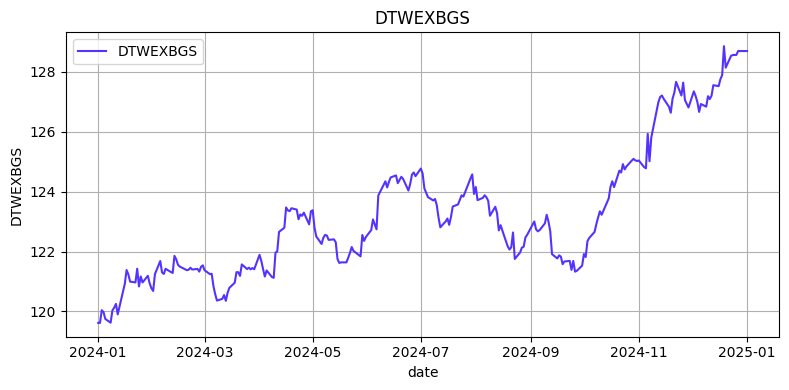

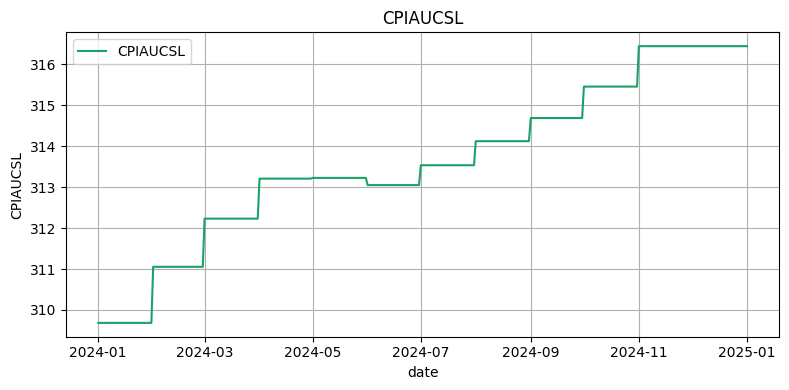

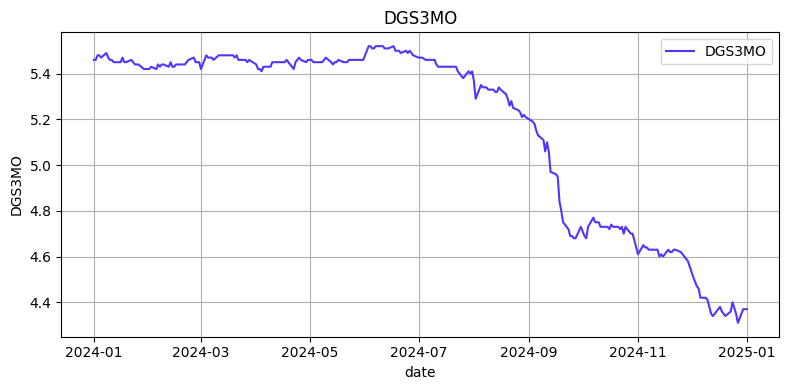

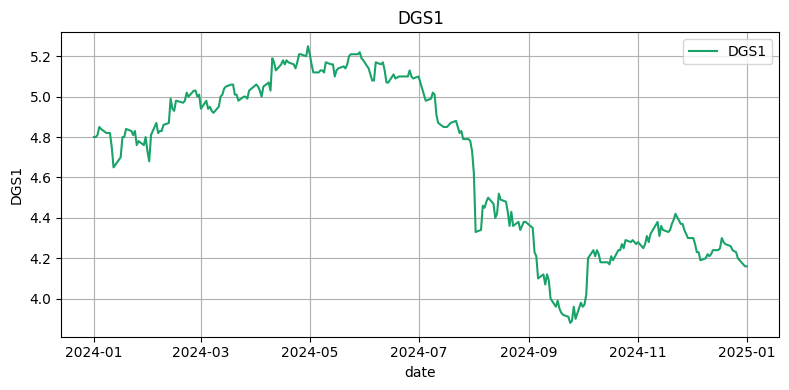

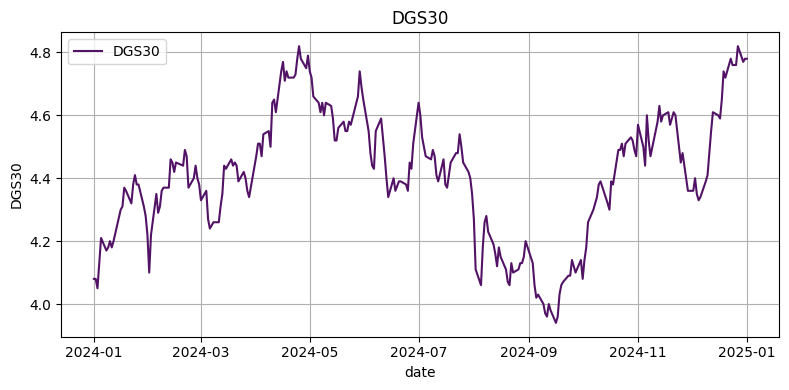

In [76]:
col_palette=['#5533FF','#19A368','#521265','#751818',"#FF5733",'#5533FF','#19A368']

for i, feature in enumerate(df_economic.columns):
    plt.figure(figsize=(8, 4))
    plt.plot(df_economic.index, df_economic[feature], label=feature, color=col_palette[i % len(col_palette)])
    plt.title(f"{feature}")
    plt.xlabel("date")
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Récupération des données X / Twitter

#### Webscraping des tweets

Je procède au scraping des tweets de comptes liés au Bitcoin en utilisant une approche parallélisée pour optimiser la vitesse et l'efficacité. Une fois collectés, les tweets sont exportés dans le dossier data/tweets

In [77]:
# # mon compte X
# LOGIN = os.getenv('LOGIN')
# PASSWORD = os.getenv('PASSWORD')

# # intervalle de temps à scraper
# since_date = datetime.strptime(start_date, "%Y-%m-%d")
# until_date = datetime.strptime(end_date, "%Y-%m-%d")

# # comptes X d'intérêt
# accounts_list = ["documentingbtc", "100trillionUSD", "CoinDesk", "saylor", "scottmelker",
#                 "woonomic", "LynAldenContact", "PrestonPysh", "PeterLBrandt", "rektcapital"]


# options = Options()
# options.add_argument('--ignore-certificate-errors')
# options.add_argument('--ignore-ssl-errors')
# options.add_argument("--disable-blink-features=AutomationControlled")

# # avec ou sans le visuel sur les pages webs
# # options.add_argument("--headless")

# # parallelisation
# with ThreadPoolExecutor(max_workers=1) as executor:
#     for account in accounts_list:
#         driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
#         # scraping des tweets d'un compte X entre 2 dates
#         executor.submit(scrape_tweets_one_account, LOGIN, PASSWORD, account, since_date, until_date, driver)

Je procède maintenant à la concaténation de tous les tweets collectés lors du processus de scraping

In [78]:
folder_path = '../data/tweets/'

csv_list = []

for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.csv'):
    
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path)
            df['author'] = str(root.split('/')[-1]) # nom raccourci au lieu du nom complet
            csv_list.append(df)

df_tweets = pd.concat(csv_list, ignore_index=True).drop_duplicates().dropna()
df_tweets.tail()

,author,timestamp,tweet_text
68,saylor - Copie,2024-12-05T15:36:24.000Z,You can still buy #bitcoin for less than $1 mi...
69,saylor - Copie,2024-12-05T14:16:41.000Z,"Year to date, $MSTR treasury operations delive..."
70,saylor - Copie,2024-12-05T13:45:36.000Z,We have a #Bitcoin President.
72,saylor - Copie,2024-12-05T13:33:29.000Z,$SMLR is a company on the #Bitcoin Standard.
73,saylor - Copie,2024-12-05T11:32:52.000Z,Keep Your Promises #Bitcoin


#### Transformation des tweets en scores de sentiment via BERTweet

Je réalise l'inférence du modèle BERTweet afin de convertir les tweets en scores de sentiment. Le modèle génère trois probabilités distinctes : négatif, neutre et positif. Ces probabilités permettent de quantifier l'émotion exprimée par le tweet.

In [79]:
tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

tweets_text = df_tweets['tweet_text'].tolist()

# prediction des scores
scores = tweets_to_sentiment_scores(tweets_text, tokenizer, model)

# ajout des scores au df
df_tweets['negative'] = scores[:, 0].tolist()
df_tweets['neutral'] = scores[:, 1].tolist()
df_tweets['positive'] = scores[:, 2].tolist()

df_tweets.head()

,author,timestamp,tweet_text,negative,neutral,positive
0,saylor,2024-12-04T20:39:49.000Z,I journeyed into the @FoxBusiness studios to d...,0.001839,0.458866,0.539295
1,saylor,2024-12-04T13:02:48.000Z,"In November, $MSTR raised $13.5 billion and ac...",0.002764,0.869330,0.127906
2,saylor,2024-12-03T21:35:51.000Z,The Deal of the Century is Trump Max #Bitcoin,0.011840,0.458442,0.529718
3,saylor,2024-12-03T14:13:32.000Z,My discussion of the economic benefits of Bitc...,0.004010,0.375384,0.620606
4,saylor,2024-12-03T12:46:43.000Z,"Last week, $MSTR's treasury operations deliver...",0.002188,0.517071,0.480741


Étant donné que tous les comptes ne tweetent pas tous les jours, j'applique une agrégation par moyenne pour consolider les données. Je regroupe les scores de sentiment par jour en calculant leur moyenne, ce qui permet d'éviter les valeurs manquantes dans les étapes ultérieures.

In [80]:
df_tweets.drop(columns=['tweet_text'], inplace=True)
df_tweets['date'] = pd.to_datetime(df_tweets['timestamp']).dt.date
df_tweets.drop(columns=['timestamp'], inplace=True)

df_tweets_agg = df_tweets.groupby(['date']).agg({
    'negative': 'mean',
    'neutral': 'mean',
    'positive': 'mean'
}).reset_index()


df_tweets_agg.index = df_tweets_agg['date']
df_tweets_agg.drop(columns=['date'], inplace=True)
df_tweets_agg.tail()

,negative,neutral,positive
date,,,
2024-12-05,0.005449,0.631689,0.362862
2024-12-06,0.036539,0.488796,0.474664
2024-12-07,0.003474,0.358726,0.637800
2024-12-08,0.431557,0.549042,0.019401
2024-12-09,0.002509,0.497012,0.500479


Je construis des variables supplémentaires à partir de ces scores

In [81]:
# pourcentage d'augmentation en 1 journée
df_tweets_agg["increase_negative"] = (df_tweets_agg["negative"] - df_tweets_agg["negative"].shift(1)) / df_tweets_agg["negative"].shift(1)
df_tweets_agg["increase_neutral"] = (df_tweets_agg["neutral"] - df_tweets_agg["neutral"].shift(1)) / df_tweets_agg["neutral"].shift(1)
df_tweets_agg["increase_positive"] = (df_tweets_agg["positive"] - df_tweets_agg["positive"].shift(1)) / df_tweets_agg["positive"].shift(1)

# moyenne mobile 7 semaines
df_tweets_agg["MA7_negative"] = df_tweets_agg["negative"].rolling(window=7).mean()
df_tweets_agg["MA7_neutral"] = df_tweets_agg["neutral"].rolling(window=7).mean()
df_tweets_agg["MA7_positive"] = df_tweets_agg["positive"].rolling(window=7).mean()

# moyenne mobile 1 mois
df_tweets_agg["MA30_negative"] = df_tweets_agg["negative"].rolling(window=30).mean()
df_tweets_agg["MA30_neutral"] = df_tweets_agg["neutral"].rolling(window=30).mean()
df_tweets_agg["MA30_positive"] = df_tweets_agg["positive"].rolling(window=30).mean()

Visualisation des variables Twitter

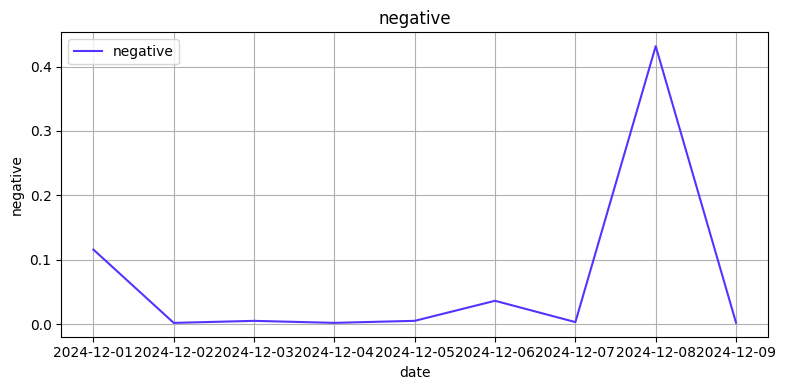

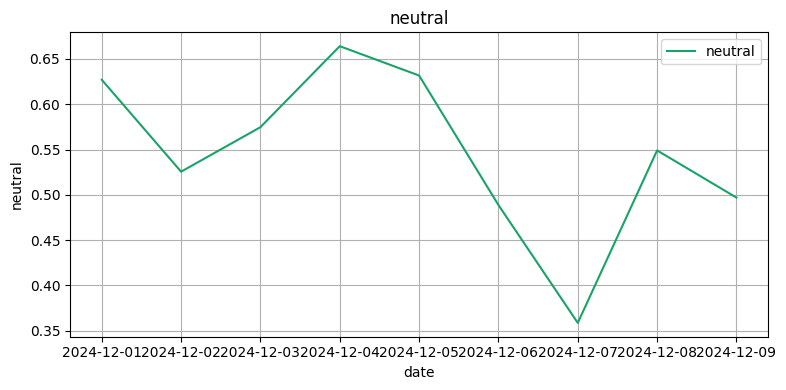

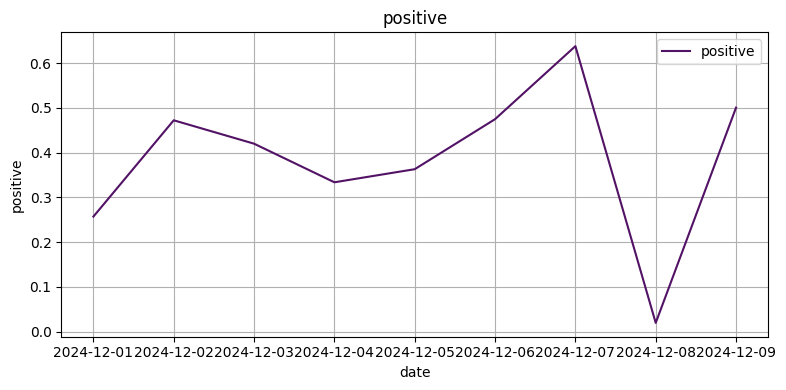

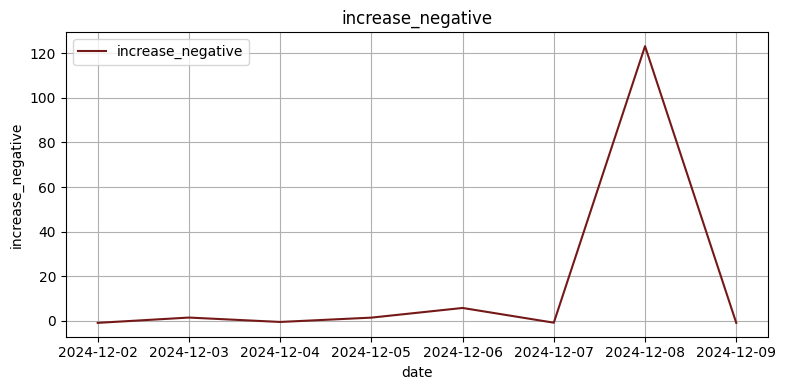

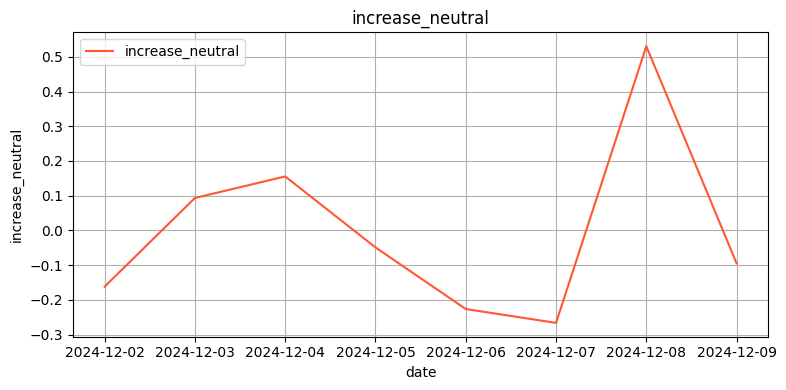

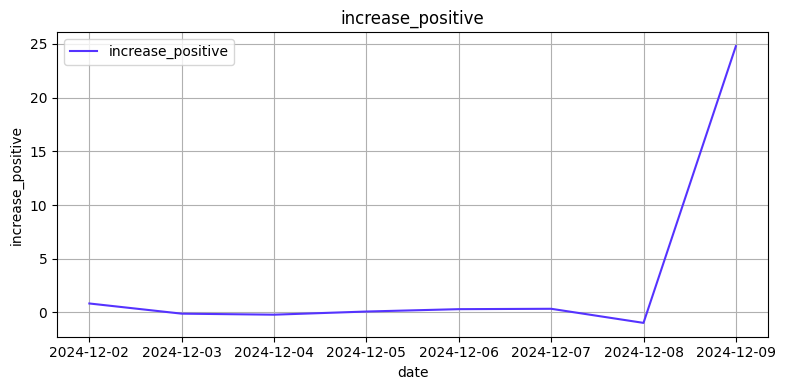

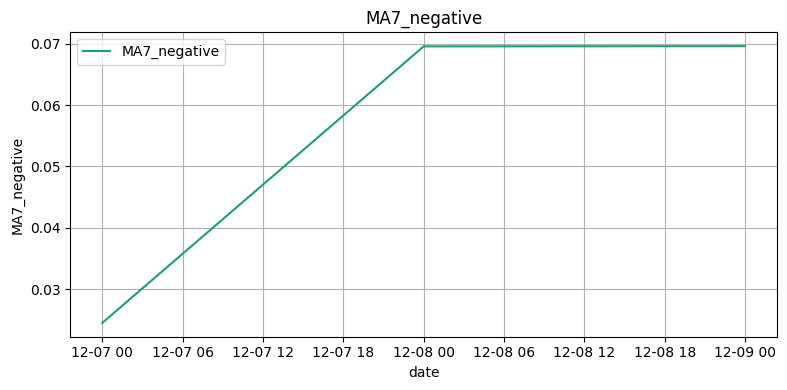

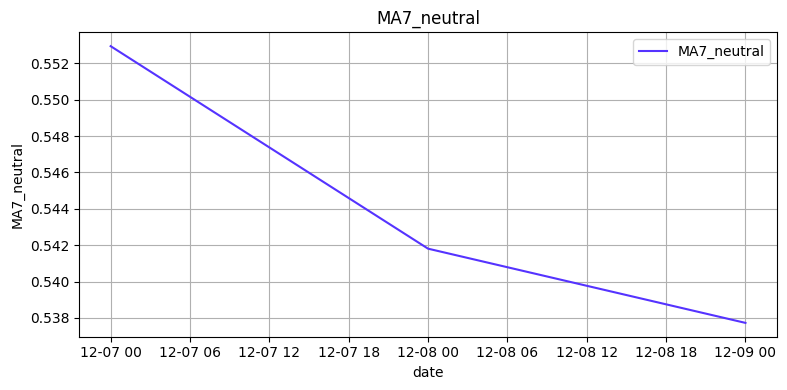

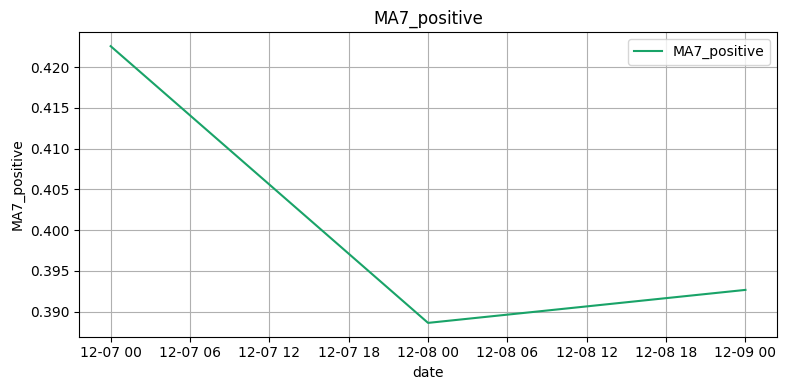

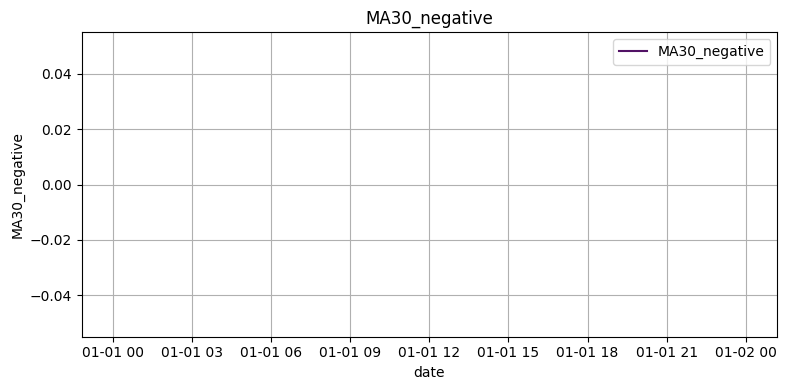

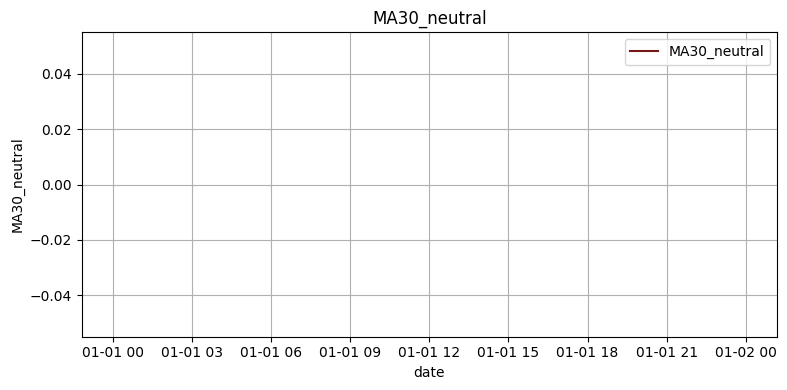

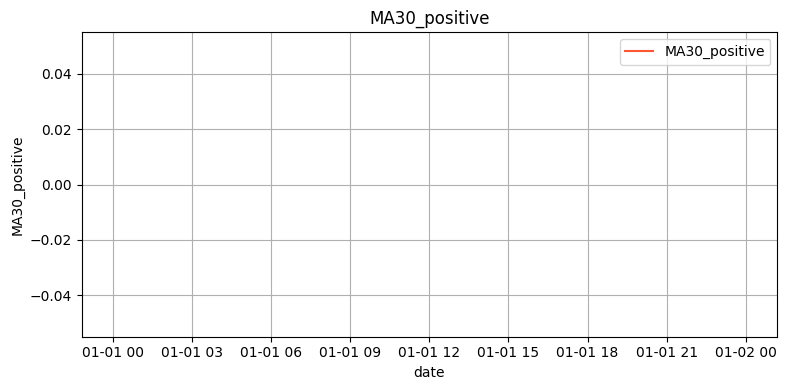

In [82]:
col_palette=['#5533FF','#19A368','#521265','#751818',"#FF5733",'#5533FF','#19A368']

for i, feature in enumerate(df_tweets_agg.columns):
    plt.figure(figsize=(8, 4))
    plt.plot(df_tweets_agg.index, df_tweets_agg[feature], label=feature, color=col_palette[i % len(col_palette)])
    plt.title(f"{feature}")
    plt.xlabel("date")
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Récupération des données Bitcoin & labélisation du prix en 3 classes

Je récupère d'abord les donénes bitcoin et je construis de variables supplémentaires

In [83]:
df_btc = get_BTC_data(days = 365, interval = 'daily')

# pct_change
df_btc["increase_volume"] = (df_btc["volume"] - df_btc["volume"].shift(1)) / df_btc["volume"].shift(1)
df_btc["increase_market_cap"] = (df_btc["market_cap"] - df_btc["market_cap"].shift(1)) / df_btc["market_cap"].shift(1)
df_btc["increase_price"] = (df_btc["price"] - df_btc["price"].shift(1)) / df_btc["price"].shift(1)

# moving average 7 semaines
df_btc["MA7_volume"] = df_btc["volume"].rolling(window=7).mean()
df_btc["MA7_market_cap"] = df_btc["market_cap"].rolling(window=7).mean()
df_btc["MA7_price"] = df_btc["price"].rolling(window=7).mean()

# moving average 1 mois
df_btc["MA30_volume"] = df_btc["volume"].rolling(window=30).mean()
df_btc["MA30_market_cap"] = df_btc["market_cap"].rolling(window=30).mean()
df_btc["MA30_price"] = df_btc["price"].rolling(window=30).mean()

# lags 1 semaine
df_btc["volume_lag_7"] = df_btc["volume"].shift(7)
df_btc["market_cap_lag_7"] = df_btc["market_cap"].shift(7)
df_btc["price_lag_7"] = df_btc["price"].shift(7)

# lags 1 mois
df_btc["volume_lag_30"] = df_btc["volume"].shift(30)
df_btc["market_cap_lag_30"] = df_btc["market_cap"].shift(30)
df_btc["price_lag_30"] = df_btc["price"].shift(30)

# date en index
df_btc.index = df_btc['date']
df_btc.drop(columns=['date'], inplace=True)
df_btc.tail()

,price,market_cap,volume,increase_volume,increase_market_cap,increase_price,MA7_volume,MA7_market_cap,MA7_price,MA30_volume,MA30_market_cap,MA30_price,volume_lag_7,market_cap_lag_7,price_lag_7,volume_lag_30,market_cap_lag_30,price_lag_30
date,,,,,,,,,,,,,,,,,,
2025-01-05 00:00:00,98256.738768,1.946611e+12,2.097904e+10,-0.412708,0.001944,0.001758,3.601728e+10,1.888064e+12,95339.427555,6.932250e+10,1.946071e+12,98304.027264,2.242985e+10,1.885557e+12,95184.619453,1.904603e+11,1.920743e+12,97201.500364
2025-01-06 00:00:00,98364.589466,1.948340e+12,2.006029e+10,-0.043793,0.000888,0.001098,3.544514e+10,1.901416e+12,96011.019262,6.613076e+10,1.945070e+12,98250.385196,2.406531e+10,1.854873e+12,93663.447520,1.158126e+11,1.978390e+12,99973.851507
2025-01-07 00:00:00,102229.394532,2.024825e+12,4.611139e+10,1.298640,0.039257,0.039291,3.380460e+10,1.928793e+12,97382.749605,6.563243e+10,1.946739e+12,98331.970680,5.759516e+10,1.833188e+12,92627.282131,6.106114e+10,1.974739e+12,99781.829992
2025-01-08 00:00:00,96952.098868,1.919133e+12,6.061026e+10,0.314431,-0.052198,-0.051622,3.598785e+10,1.938406e+12,97874.783908,6.556351e+10,1.943936e+12,98189.194919,4.532746e+10,1.851840e+12,93507.858747,6.267776e+10,2.003239e+12,101235.371703
2025-01-08 00:40:32,97111.119022,1.922809e+12,5.942116e+10,-0.019619,0.001915,0.001640,4.115159e+10,1.946065e+12,98264.347180,6.264932e+10,1.943828e+12,98181.100653,2.327501e+10,1.869193e+12,94384.176115,1.468468e+11,1.926048e+12,97353.947008


Visualisation des variables Bitcoin

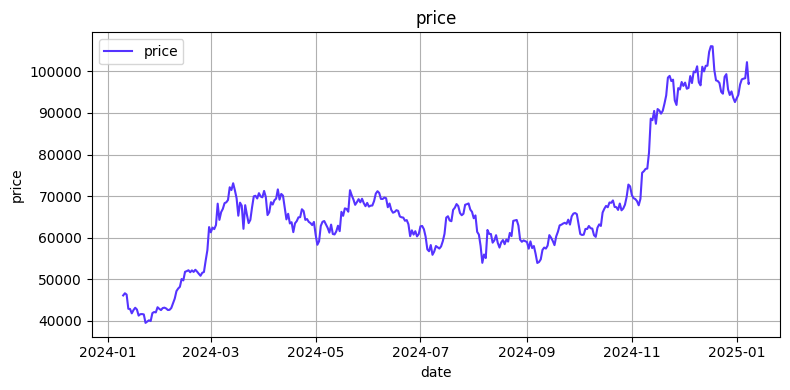

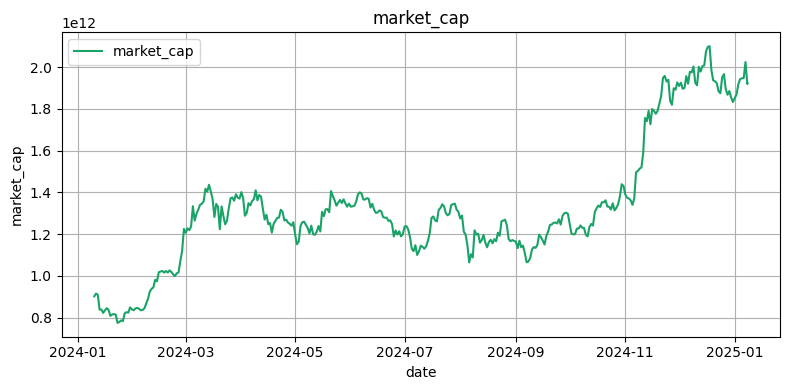

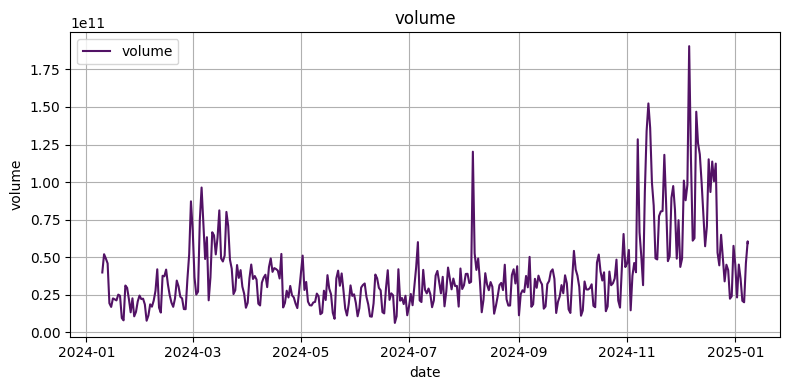

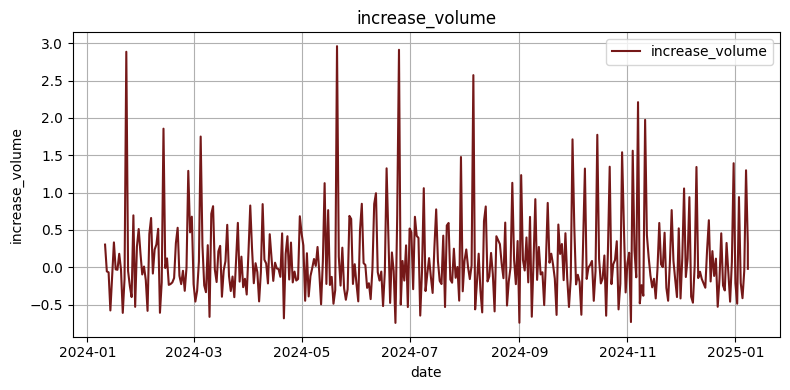

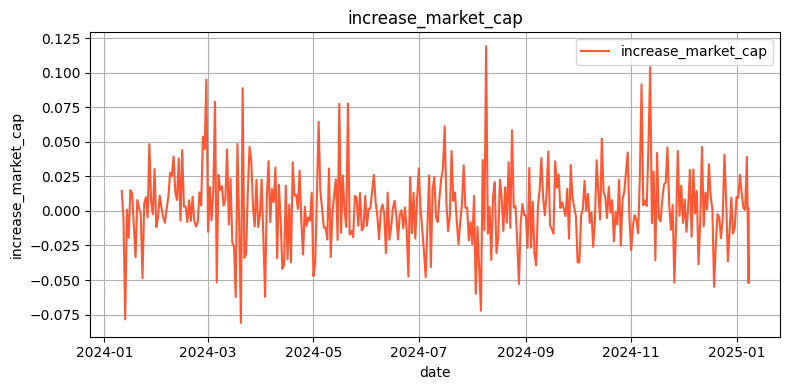

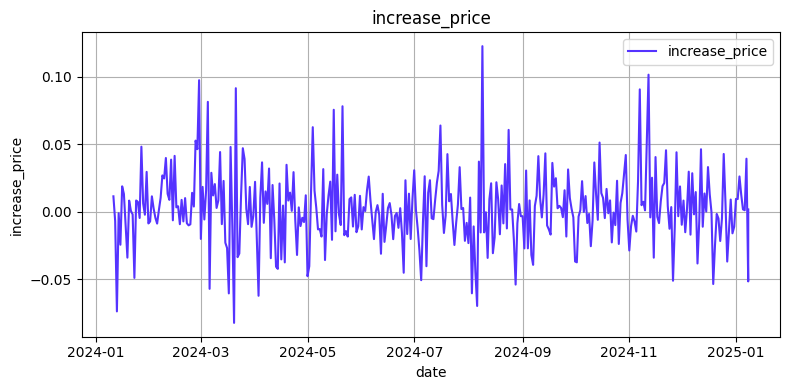

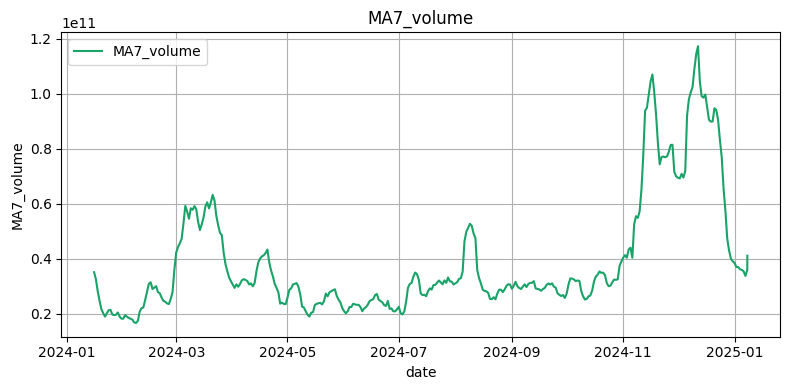

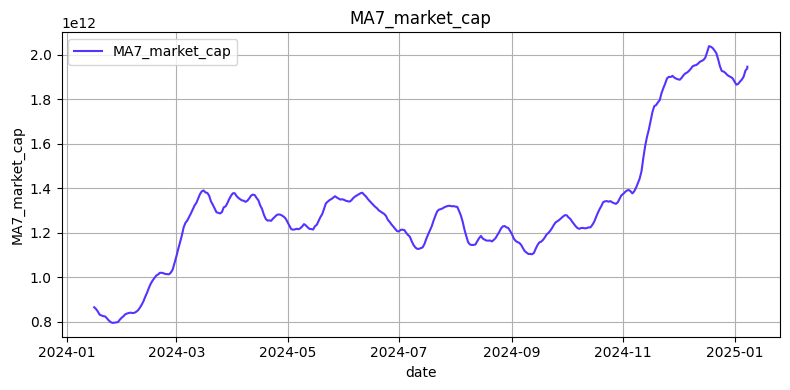

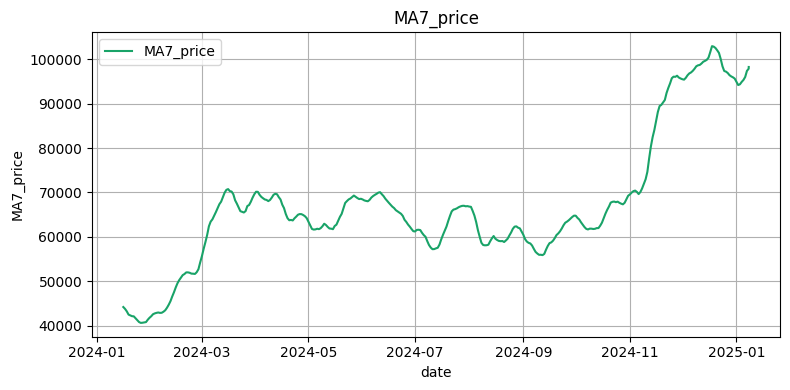

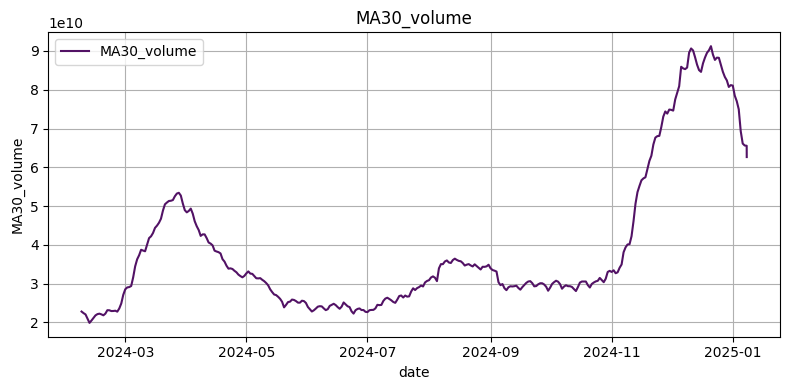

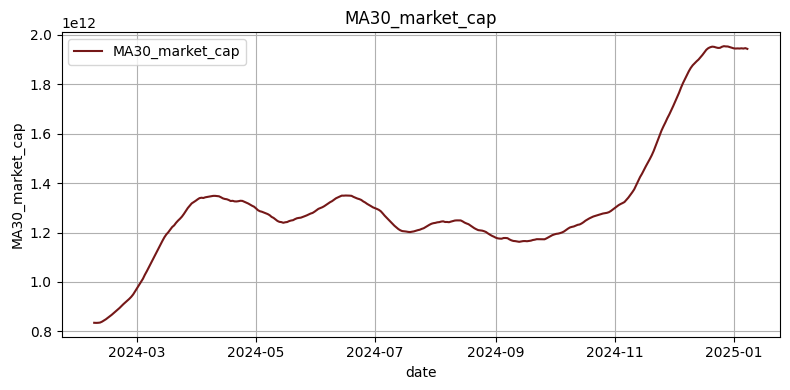

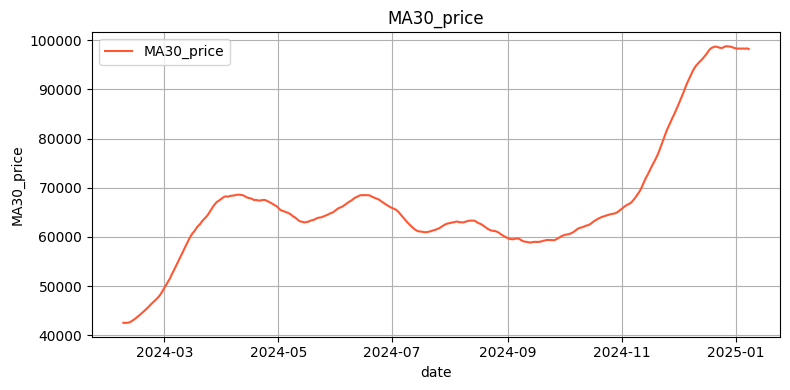

In [84]:
col_palette=['#5533FF','#19A368','#521265','#751818',"#FF5733",'#5533FF','#19A368']

for i, feature in enumerate(df_btc.columns[:12]):
    plt.figure(figsize=(8, 4))
    plt.plot(df_btc.index, df_btc[feature], label=feature, color=col_palette[i % len(col_palette)])
    plt.title(f"{feature}")
    plt.xlabel("date")
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Labelisation du prix du bitcoin avec une méthode Triple barrier optimisée via optimisation génétique

Je procède à la classification du prix du Bitcoin en trois catégories distinctes : buy, hold et sell. Cette classification repose sur la méthode des Triple Barriers, qui détermine les seuils de prix à partir desquels chaque catégorie est attribuée. Afin d'optimiser les trois barrières ainsi que les deux montants associés, j'emploie un algorithme génétique. Cet outil puissant permet d'explorer de manière efficace l'espace des paramètres, identifiant ainsi la configuration optimale pour maximiser la performance d'une stratégie de trading (equity strategy).

Je procède d'abord au choix du profil de risque : High risk & High profit ou Low risk & Low profit.
1. Stratégie pour profil **High Risk, High Profit**  
   - Optimisation : Maximisation de 0.7 * profit - 0.3 * maximum drawdown   

2. Stratégie pour profil **Low Risk, Low Profit**  
   - Optimisation : Maximisation de 0.3 * profit - 0.7 * maximum drawdown  

In [85]:
risk_profile = 'HRHP' # or LRLP

In [86]:

if risk_profile == 'HRHP':
    risk_profile_type_dict = {'weight_p':0.7, 'weight_mdd':0.3} # High risk High profit
else:
    risk_profile_type_dict = {'weight_p':0.3, 'weight_mdd':0.7} # Low risk Low profit

Algorithme d'optimisation génétique

In [87]:
# DEAP settings
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # goal : maximizing fitness value
creator.create("Individual", list, fitness=creator.FitnessMax) # individual lists definition

# defining individuals and population
toolbox = base.Toolbox()

# defining constraints
toolbox.register("attr_lower_barrier", random.uniform, -0.5, 0)
toolbox.register("attr_upper_barrier", random.uniform, 0, 0.5)
toolbox.register("attr_time_barrier", random.randint, 1, 1000)
toolbox.register("attr_buy_number", random.randint, 1, 10)
toolbox.register("attr_sell_number", random.randint, 1, 10)

# defining creation of one individual
toolbox.register("individual", tools.initCycle, creator.Individual,
                (toolbox.attr_lower_barrier,
                toolbox.attr_upper_barrier,
                toolbox.attr_time_barrier,
                toolbox.attr_buy_number,
                toolbox.attr_sell_number),
                n=1)

# defining creation of the population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# defining computation fitness function
toolbox.register("evaluate", partial(evaluate_individual, weight_p=risk_profile_type_dict['weight_p'], 
                                     weight_mdd=risk_profile_type_dict['weight_mdd'], 
                                     target_price=df_btc['price']))

# defining genetic operations
toolbox.register("mate", tools.cxBlend, alpha=0.5) # crossover / alpha : crossover variability
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2) # mutation / random draw in gaussian distribution
toolbox.register("select", tools.selTournament, tournsize=5) # selection / 5 individuals chosen

# launch the optimization
best_individual, best_fitness = run_genetic_algorithm(toolbox, population_size= 50, nb_gen=5, crossover=0.7, mutation=0.2)

c:\Users\lebre\OneDrive\Bureau\Finance Quant_S9\Projet_QF\Scripts\.venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\lebre\OneDrive\Bureau\Finance Quant_S9\Projet_QF\Scripts\.venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



---------------------------------------- Generation 1/5 ----------------------------------------

Individual: [-1.600e-01  4.000e-01  7.627e+02  8.420e+00  2.560e+00], Fitness: [0.]
Individual: [-5.000e-01  4.100e-01  9.413e+02  9.580e+00  6.440e+00], Fitness: [0.]
Individual: [-4.7000e-01  1.5000e-01  3.5836e+02  7.4300e+00  8.0200e+00], Fitness: [1865895.83]
Individual: [-4.1000e-01  2.0000e-02  8.4364e+02  6.5700e+00  9.9800e+00], Fitness: [0.]
Individual: [-1.90e-01  2.80e-01  9.45e+02  6.00e+00  6.00e+00], Fitness: [0.]
Individual: [-1.00e-02  2.80e-01  1.81e+02  8.00e+00  5.00e+00], Fitness: [2141217.09]
Individual: [-1.90000e-01  2.50000e-01  1.08448e+03  2.73000e+00  6.05000e+00], Fitness: [0.]
Individual: [-2.4000e-01  1.3000e-01  1.9952e+02  6.2700e+00  6.9500e+00], Fitness: [17132863.76]
Individual: [-5.00e-02  4.20e-01  7.69e+02  5.00e+00  5.00e+00], Fitness: [0.]
Individual: [-1.10e-01  5.00e-01  3.87e+02  9.00e+00  3.00e+00], Fitness: [0.]
Individual: [  -0.48    0.42 -2

Je procède maintenant à l'affichage des labels générés à l'aide de la méthode des Triple Barriers, dont les paramètres ont été préalablement optimisés.

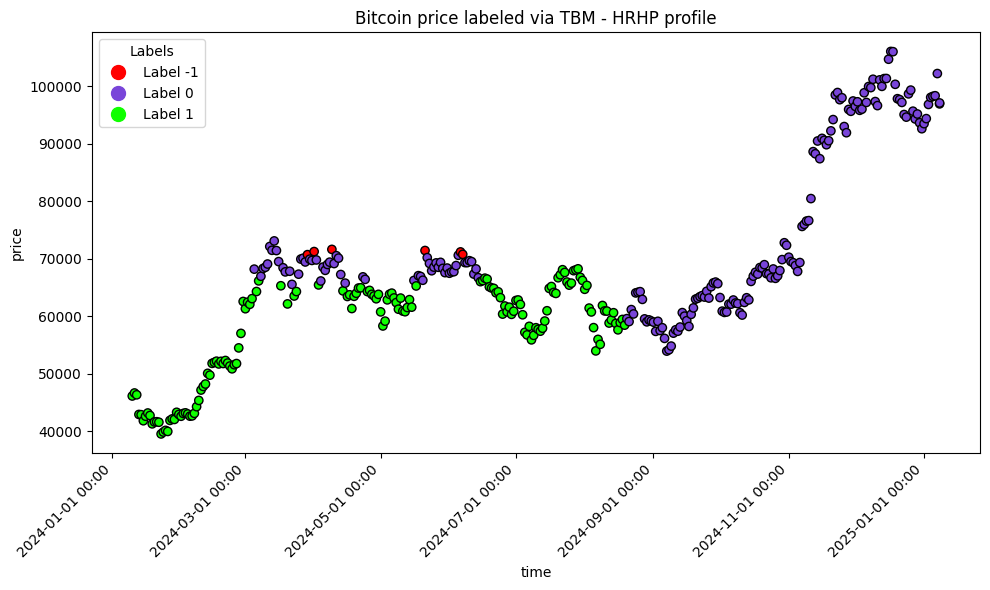

In [88]:
# plot best individual using its TBM with its labels
tbm = TripleBarrierMethod(df_btc['price'], lower_barrier=best_individual[0], upper_barrier=best_individual[1], time_barrier=int(best_individual[2]))
df_btc_price_labeled = tbm.label_data()
tbm.plot_labels(colors=['#ff0000', '#7945d9', '#0fff00'], title=f'Bitcoin price labeled via TBM - {risk_profile} profile')

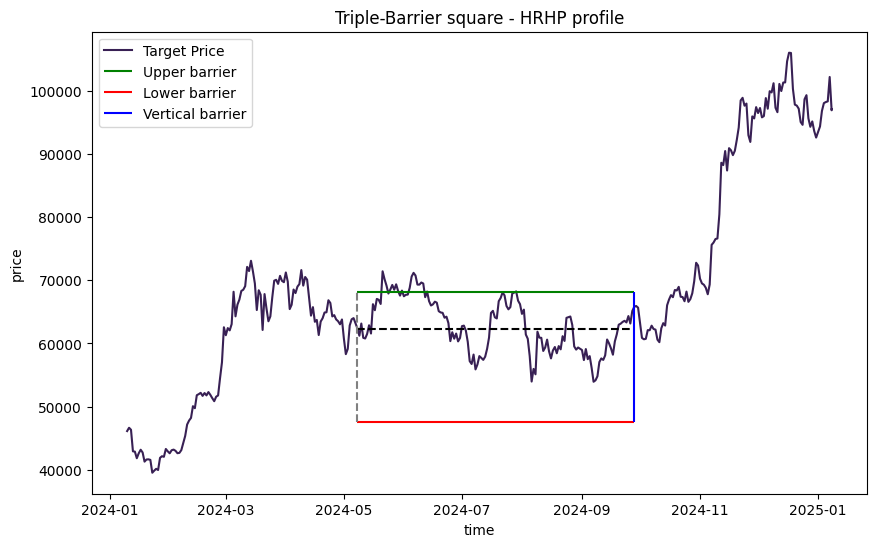

In [89]:
# plot best individual TBM square
tbm.plot_square(date='2024-05-08 00:00:00', title=f'Triple-Barrier square - {risk_profile} profile')

In [90]:
# ajout du label buy, hold ou sell défini par la Triple Barrier method au df
df_btc['tbm label'] = df_btc_price_labeled['label']
df_btc.tail(2)

,price,market_cap,volume,increase_volume,increase_market_cap,increase_price,MA7_volume,MA7_market_cap,MA7_price,MA30_volume,MA30_market_cap,MA30_price,volume_lag_7,market_cap_lag_7,price_lag_7,volume_lag_30,market_cap_lag_30,price_lag_30,tbm label
date,,,,,,,,,,,,,,,,,,,
2025-01-08 00:00:00,96952.098868,1.919133e+12,6.061026e+10,0.314431,-0.052198,-0.051622,3.598785e+10,1.938406e+12,97874.783908,6.556351e+10,1.943936e+12,98189.194919,4.532746e+10,1.851840e+12,93507.858747,6.267776e+10,2.003239e+12,101235.371703,0
2025-01-08 00:40:32,97111.119022,1.922809e+12,5.942116e+10,-0.019619,0.001915,0.001640,4.115159e+10,1.946065e+12,98264.347180,6.264932e+10,1.943828e+12,98181.100653,2.327501e+10,1.869193e+12,94384.176115,1.468468e+11,1.926048e+12,97353.947008,0


### Création du dataframe final d'entrainement de test et exportation de 2 paramètres de la Triple Barrier method

Jointure des 3 datasets via la date journalière.

In [98]:
df_btc.index = pd.to_datetime(df_btc.index).date
df_complet = df_btc.join([df_economic, df_tweets_agg], how='inner')

Vérification des valeurs manquantes

In [99]:
na_taux = df_complet.isna().sum() / len(df_complet)
print('taux valeurs manquantes:', na_taux.sort_values(ascending=False))
df_complet.head()


taux valeurs manquantes: MA30_positive          1.000000
MA30_neutral           1.000000
MA30_negative          1.000000
MA7_positive           0.666667
MA7_neutral            0.666667
MA7_negative           0.666667
increase_positive      0.111111
increase_neutral       0.111111
increase_negative      0.111111
DGS1                   0.000000
DPCREDIT               0.000000
DTWEXBGS               0.000000
CPIAUCSL               0.000000
DGS3MO                 0.000000
positive               0.000000
DGS30                  0.000000
negative               0.000000
neutral                0.000000
FINCP                  0.000000
DPRIME                 0.000000
price                  0.000000
market_cap             0.000000
DFF                    0.000000
volume                 0.000000
increase_volume        0.000000
increase_market_cap    0.000000
increase_price         0.000000
MA7_volume             0.000000
MA7_market_cap         0.000000
MA7_price              0.000000
MA30_volume    

,price,market_cap,volume,increase_volume,increase_market_cap,increase_price,MA7_volume,MA7_market_cap,MA7_price,MA30_volume,...,positive,increase_negative,increase_neutral,increase_positive,MA7_negative,MA7_neutral,MA7_positive,MA30_negative,MA30_neutral,MA30_positive
2024-12-01,96513.142347,1.910023e+12,4.358002e+10,-0.416365,-0.008721,-0.009647,6.947408e+10,1.889494e+12,95508.804779,7.481985e+10,...,0.256975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-02,97311.707191,1.925808e+12,4.914769e+10,0.127757,0.008265,0.008274,6.925723e+10,1.887546e+12,95408.200731,7.462934e+10,...,0.472155,-0.980544,-0.161754,0.837356,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-03,95833.136230,1.896577e+12,1.010199e+11,1.055435,-0.015179,-0.015194,7.090630e+10,1.895802e+12,95812.262917,7.750635e+10,...,0.419868,1.395960,0.093487,-0.110740,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-04,96031.630978,1.900922e+12,8.793575e+10,-0.129520,0.002291,0.002071,6.955581e+10,1.907363e+12,96397.948660,7.918223e+10,...,0.333601,-0.574424,0.155508,-0.205464,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-05,98881.469456,1.957276e+12,9.823078e+10,0.117074,0.029646,0.029676,7.195030e+10,1.915676e+12,96812.275644,8.091715e+10,...,0.362862,1.367539,-0.048801,0.087713,NaN,NaN,NaN,NaN,NaN,NaN


Export des datasets train et test

In [100]:
df_train, df_test = train_test_split(df_complet, test_size=0.2, shuffle=True, random_state=1111)

df_train.to_csv(f'../data/train_{risk_profile}.csv', index=True)
df_test.to_csv(f'../data/test_{risk_profile}.csv', index=True)

Exportation des 4ᵉ et 5ᵉ paramètres de la méthode des Triple Barriers (TBM) :
1. buy_number  
   - montant en dollars (sur 100 dollars de cash) à investir pour acheter du Bitcoin lorsqu'un signal d'achat est détecté 

2. sell_number  
   - montant en dollars à récupérer (sur 100 dollars de cash) lors de la vente de Bitcoin lorsqu'un signal de vente est détecté

In [101]:
tbm_parameters = {'buy_number': best_individual[3], 'sell_number': best_individual[4], "fitness":best_fitness}
print(tbm_parameters)
file_path = f"../data/tbm_parameters_{risk_profile}.json"

with open(file_path, "w") as json_file:
    json.dump(tbm_parameters, json_file, indent=1)

{'buy_number': 9.780756171341274, 'sell_number': 1.9218778319100314, 'fitness': 36722101.840193406}
